## CS310 Natural Language Processing
## Assignment 2. Word2vec Implementation 

**Total points**: 50

Train a word2vec model using the **skip-gram** architecture and **negative sampling**.

You should roughtly follow the structure of the notebook. Add additional cells if you feel needed. 

You can (and you should) re-use the code from *Lab 4 (part 2): Data preparation for implementing word2vec*. 

Make sure your code is readable and well-structured.

### 0. Import Necessary Libraries

In [2]:
from typing import List
from utils import CorpusReader
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD


## 1. Data Processing

The corpus data is in `lunyu_20chapters.txt`. Use the `CorpusReader` class in `utils.py` to help you.

In [3]:
# Read raw data in lunyu_20chapters.txt
lunyu_url = 'lunyu_20chapters.txt'
with open(lunyu_url, 'r', encoding='utf-8') as file:
    raw_data = file.read()
raw_data = raw_data.replace('\n', '')
print(raw_data)

子曰：学而时习之，不亦说乎？有朋自远方来，不亦乐乎？人不知而不愠，不亦君子乎？有子曰：其为人也孝弟，而好犯上者，鲜矣；不好犯上而好作乱者，未之有也。君子务本，本立而道生。孝弟也者，其为仁之本与！子曰：巧言令色，鲜矣仁！曾子曰：吾日三省吾身：为人谋而不忠乎？与朋友交而不信乎？传不习乎？子曰：道千乘之国，敬事而信，节用而爱人，使民以时。子曰：弟子入则孝，出则弟，谨而信，泛爱众，而亲仁，行有余力，则以学文。子夏曰：贤贤易色；事父母，能竭其力；事君，能致其身；与朋友交，言而有信。虽曰未学，吾必谓之学矣。子曰：君子不重则不威，学则不固。主忠信，无友不如己者，过，则勿惮改。曾子曰：慎终追远，民德归厚矣。子禽问于子贡曰：夫子至于是邦也，必闻其政，求之与，抑与之与？子贡曰：夫子温、良、恭、俭、让以得之。夫子之求之也，其诸异乎人之求之与？子曰：父在，观其志；父没，观其行；三年无改于父之道，可谓孝矣。有子曰：礼之用，和为贵。先王之道，斯为美。小大由之，有所不行。知和而和，不以礼节之，亦不可行也。有子曰：信近于义，言可复也。恭近于礼，远耻辱也。因不失其亲，亦可宗也。子曰：君子食无求饱，居无求安，敏于事而慎于言，就有道而正焉，可谓好学也已。子贡曰：贫而无谄，富而无骄，何如？子曰：可也。未若贫而乐，富而好礼者也。子贡曰：《诗》云：如切如磋，如琢如磨，其斯之谓与？子曰：赐也，始可与言《诗》已矣，告诸往而知来者。子曰：不患人之不己知，患不知人也。子曰：为政以德，譬如北辰，居其所而众星共之。子曰：《诗》三百，一言以蔽之，曰：思无邪。子曰：道之以政，齐之以刑，民免而无耻。道之以德，齐之以礼，有耻且格。子曰：吾十有五而志于学，三十而立，四十而不惑，五十而知天命，六十而耳顺，七十而从心所欲，不逾矩。孟懿子问孝，子曰：无违。樊迟御，子告之曰：孟孙问孝于我，我对曰无违。樊迟曰：何谓也？子曰：生，事之以礼；死，葬之以礼，祭之以礼。孟武伯问孝。子曰：父母唯其疾之忧。子游问孝。子曰：今之孝者，是谓能养。至于犬马，皆能有养；不敬，何以别乎？子夏问孝。子曰：色难。有事，弟子服其劳；有酒食，先生馔，曾是以为孝乎？子曰：吾与回言终日，不违，如愚。退而省其私，亦足以发，回也不愚。子曰：视其所以，观其所由，察其所安，人焉廋哉？人焉廋哉？子曰：温故而知新，可以为师矣。子曰：君子不器。子贡问君子。子曰：先行其言而后从之。子曰：君

In [4]:
corpus = CorpusReader(lunyu_url, min_count=1)
print(corpus.word2id["子"])
print(corpus.id2word[1])
print(len(corpus.id2word))

Total vocabulary: 1352
1
子
1352


In [5]:
# Re-use the code from lab with necessary modifications
def generate_data(words: List[str], window_size: int, k: int, corpus: CorpusReader):
    """ Generate the training data for word2vec skip-gram model
    Args:
        text: the input text
        window_size: the size of the context window
        k: the number of negative samples
        corpus: the corpus object, providing utilities such as word2id, getNegatives, etc.
    """
    ### YOUR CODE HERE ###
    # convert the list of words to a list of word ids
    word_ids = [corpus.word2id[word] for word in words if word in corpus.word2id]
    #terate through each word #
    for i, center_word in enumerate(word_ids):
        start = max(0, i - window_size)
        end = min(len(word_ids), i + window_size + 1)

        #Select outside words (excluding the center word) #
        for j in range(start, end):
            if i != j:  # Exclude center word itself
                outside_word = word_ids[j]

                #Get negative samples #
                negative_samples = np.array(corpus.getNegatives(center_word, k))  # Convert to NumPy array

                #Yield the training tuple #
                yield (center_word, outside_word, negative_samples)
    ### END YOUR CODE ###


def batchify(data: List, batch_size: int):
    """ Group a stream into batches and yield them as torch tensors.
    Args:
        data: a list of tuples
        batch_size: the batch size 
    Yields:
        a tuple of three torch tensors: center, outside, negative
    """
    assert batch_size < len(data)  # data should be long enough
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        if i > len(data) - batch_size:  # if the last batch is smaller than batch_size, pad it with the first few data
            batch = batch + data[:i + batch_size - len(data)]

        ### YOUR CODE HERE ###
        center_words, outside_words, negative_samples = zip(*batch)

        # 转换为 PyTorch tensors
        center_tensor = torch.tensor(center_words, dtype=torch.long)  # shape: (batch_size,)
        outside_tensor = torch.tensor(outside_words, dtype=torch.long)  # shape: (batch_size,)
        negative_tensor = torch.tensor(negative_samples, dtype=torch.long)  # shape: (batch_size, k)

        yield center_tensor, outside_tensor, negative_tensor
        ### END YOUR CODE ###

## 2. Define the Model

In [6]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(SkipGram, self).__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.emb_v = nn.Embedding(vocab_size, emb_size, sparse=True)
        self.emb_u = nn.Embedding(vocab_size, emb_size, sparse=True)

        initrange = 1.0 / self.emb_size  # some experience passed down from generation to generation
        nn.init.uniform_(self.emb_v.weight.data, -initrange,
                         initrange)  # same outcome as self.emb_v.weight.data.uniform_(-initrange, initrange)
        nn.init.constant_(self.emb_u.weight.data, 0)  # same outcome as self.emb_u.weight.data.zero_()

    def forward(self, center, outside, negative):
        """
        Args:
            center: the center word indices (B, )
            outside: the outside word indices (B, )
            negative: the negative word indices (B, k)
        """
        v_c = self.emb_v(center)
        u_o = self.emb_u(outside)
        u_n = self.emb_u(negative)

        ### YOUR CODE HERE ###
        # Hint: torch.clamp the input to F.logsigmoid to avoid numerical underflow/overflow
        pos_score = torch.sum(torch.mul(v_c, u_o), dim=1)
        pos_loss = F.logsigmoid(torch.clamp(pos_score, min=-10, max=10))

        # Negative sample scores
        neg_score = torch.bmm(u_n, v_c.unsqueeze(2)).squeeze(2)
        neg_loss = F.logsigmoid(torch.clamp(-neg_score, min=-10, max=10))

        # Combine losses
        loss = -torch.sum(pos_loss + torch.sum(neg_loss, dim=1))  # Scalar
        ### END YOUR CODE ###

        return loss

    def save_embedding(self, id2word, file_name):
        embedding = self.emb_v.weight.cpu().data.numpy()
        with open(file_name, 'w') as f:
            f.write('%d %d\n' % (len(id2word), self.emb_size))
            for wid, w in id2word.items():
                e = ' '.join(map(lambda x: str(x), embedding[wid]))
                f.write('%s %s\n' % (w, e))

## 3. Train and Evaluate

In [24]:
from tqdm import tqdm


def train(model, dataloader, optimizer, scheduler, epochs, device):
    # Write your own code for this train function
    # You don't need exactly the same arguments
    model.train()  # Set model to training mode
    for epoch in range(epochs):
        total_loss = 0
        for center, outside, negative in tqdm(dataloader):
            center, outside, negative = center.to(device), outside.to(device), negative.to(device)
            optimizer.zero_grad()  # Reset gradients
            loss = model(center, outside, negative)
            loss.backward()  # Backpropagate
            optimizer.step()  # Update weights
            total_loss += loss.item()
        scheduler.step()
        print(f'Epoch {epoch} Average Loss: {total_loss / len(dataloader):.4f}')


# Suggested hyperparameters
initial_lr = 0.025
batch_size = 16
epochs = 10  # 训练轮数
emb_size = 50
window_size = 5
k = 10  # the number of negative samples, change with your own choice for better embedding performance
min_count = 1  # because our data is small. If min_count > 1, you should filter out those unknown words from the data in train() function

# Initialize the corpus and model
# corpus = CorpusReader('lunyu_20chapters.txt', min_count)
vocab_size = corpus.vocab_size
model = SkipGram(vocab_size, emb_size)
optimizer = torch.optim.SparseAdam(model.parameters(), initial_lr)  # or torch.optim.SparseAdam()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)  # or torch.optim.lr_scheduler.StepLR()

data = list(generate_data(raw_data, window_size=window_size, k=k, corpus=corpus))
batches = list(batchify(data, batch_size=batch_size))
device = torch.device("cpu")
model.to(device)
# batches = batches.to(device)
train(model, batches, optimizer, scheduler, epochs, device)


### Hints: ###
# - If you have cuda-supported GPUs, you can run the training faster by
#   `device = torch.device("cuda" if self.use_cuda else "cpu")`
#   `model.cuda()`
#   You also need to move all tensor data to the same device
# - If you find Inf or NaN in the loss, you can try to clip the gradient usning `torch.nn.utils.clip_grad_norm_`
# - Remember to save the embeddings when training is done

100%|██████████| 12420/12420 [00:24<00:00, 507.94it/s]


Epoch 0 Average Loss: 65.1386


100%|██████████| 12420/12420 [00:24<00:00, 516.52it/s]


Epoch 1 Average Loss: 55.0955


100%|██████████| 12420/12420 [00:23<00:00, 535.17it/s]


Epoch 2 Average Loss: 51.9217


100%|██████████| 12420/12420 [00:24<00:00, 516.44it/s]


Epoch 3 Average Loss: 49.8888


100%|██████████| 12420/12420 [00:24<00:00, 508.10it/s]


Epoch 4 Average Loss: 48.4827


100%|██████████| 12420/12420 [00:24<00:00, 497.55it/s]


Epoch 5 Average Loss: 47.4190


100%|██████████| 12420/12420 [00:24<00:00, 506.38it/s]


Epoch 6 Average Loss: 46.5926


100%|██████████| 12420/12420 [00:25<00:00, 494.19it/s]


Epoch 7 Average Loss: 45.9748


100%|██████████| 12420/12420 [00:24<00:00, 503.66it/s]


Epoch 8 Average Loss: 45.5434


100%|██████████| 12420/12420 [00:24<00:00, 508.74it/s]

Epoch 9 Average Loss: 45.2357


## 4. Save the Embeddings


Save the embeddings into a `gensim` compatible format.

In [61]:
output_file = 'embeddingsTXT/embeddings.txt'
weights = model.emb_v.weight.detach().numpy()
with open(output_file, "w") as f:
    f.write(f"{vocab_size} {emb_size}\n")  # First line: vocab size and vector dimension
    for idx in range(vocab_size):
        if idx in corpus.id2word:  # 确保索引在id2word中存在
            word = corpus.id2word[idx]
            vector_str = " ".join(map(str, weights[idx]))
            f.write(f"{word} {vector_str}\n")

## 5. Plot and Compare Embeddings

Use `sklearn.decomposition.TruncatedSVD` to reduce the dimensionality of the obtained embeddings to 2 and plot the selected words in 2D space.

*Hint*:
- Obtain the embeddings into a numpy array by `model.emb_v.cpu().data.numpy()`
- The word2id dictionary is in `model.word2id`
- If you are trying to load from a saved embedding file, you can use the APIs from `gensim`.
  - For exmaple, `model = gensim.models.KeyedVectors.load_word2vec_format('path/to/file')`
  - Check out the documentation for more details: https://radimrehurek.com/gensim/models/keyedvectors.html

In [84]:
# Load embeddings
### YOUR CODE HERE ###
def load_embeddings(file_path):
    """Load embeddings from a file and return a dictionary of word to vector"""
    embeddings = {}
    with open(file_path, 'r') as f:
        # Skip the first line as it contains metadata (word count and embedding size)
        f.readline()
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            embeddings[word] = vector
    return embeddings


words = ['学', '习', '曰', '子', '人', '仁']
words_pinyin = ['xue', 'xi', 'yue', 'zi', 'ren1', 'ren2']
embedding_file = 'embeddingsTXT/embeddings.txt'
embeddings = load_embeddings(embedding_file)
target_embeddings = np.array([embeddings[word] for word in words if word in embeddings])
### END YOUR CODE ###

In [85]:
# Truncated SVD
### YOUR CODE HERE ###
svd = TruncatedSVD(n_components=2)
reduced_embeddings = svd.fit_transform(target_embeddings)
### END YOUR CODE ###

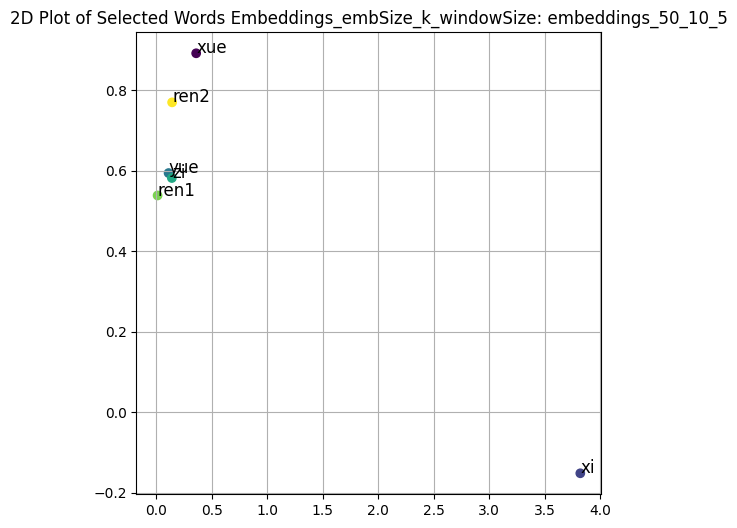

<Figure size 640x480 with 0 Axes>

In [86]:
# Plot the following words or other words you are interested in
# You better pick those words that look different in the 2D space compared with the LSA vectors
### YOUR CODE HERE ###
plt.figure(figsize=(6, 6))
colors = np.linspace(0, 1, len(words))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors, cmap='viridis')

# Annotate the words on the plot
for i, word in enumerate(words):
    if word in embeddings:
        plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], words_pinyin[i], fontsize=12)

plt.title(f'2D Plot of Selected Words Embeddings_embSize_k_windowSize: embeddings_50_10_5')
plt.grid(True)
plt.show()
plt.savefig('embedding_plot_50_10_5.png', dpi=300)  # Save as PNG with 300 DPI
### END YOUR CODE ###

## 6. different hyper-parameters

In [10]:
import time
from tqdm import tqdm
import torch

# Suggested hyperparameters
initial_lr = 0.025
batch_size = 16
epochs = 10  # 训练轮数
min_count = 1  # because our data is small. If min_count > 1, you should filter out those unknown words from the data in train() function


def grid_search_training(corpus, raw_data, epochs=10, batch_size=16, initial_lr=0.025, device='cpu'):
    emb_sizes = [50, 100]
    k_values = [2, 5]
    window_sizes = [1, 3]
    experiment_results = []
    for emb_size in emb_sizes:
        for k in k_values:
            for window_size in window_sizes:
                print(f"------------------------embeddings_{emb_size}_{k}_{window_size}--------------------")
                # Initialize model, optimizer, and scheduler for each combination
                model = SkipGram(corpus.vocab_size, emb_size)  # Initialize the model with the current emb_size
                optimizer = torch.optim.SparseAdam(model.parameters(), initial_lr)
                scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
                # Prepare the data
                data = list(generate_data(raw_data, window_size=window_size, k=k, corpus=corpus))
                batches = list(batchify(data, batch_size=batch_size))
                model.to(device)
                # Measure the training time
                start_time = time.time()
                # Train the model
                train(model, batches, optimizer, scheduler, epochs, device)
                end_time = time.time()

                file_name = f"embeddings_{emb_size}_{k}_{window_size}.txt"
                model.save_embedding(corpus.id2word, file_name)

                computation_time = end_time - start_time  # Compute the time taken
                # Store the results for each experiment
                experiment_results.append({
                    'emb_size': emb_size,
                    'k': k,
                    'window_size': window_size,
                    'computation_time': computation_time
                })

    # After grid search, you can print or return the results
    for result in experiment_results:
        print(f"emb_size: {result['emb_size']}, k: {result['k']}, window_size: {result['window_size']}, "
              f"Computation Time: {result['computation_time']:.4f} seconds")


# Assuming you already have your corpus and raw_data loaded:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grid_search_training(corpus, raw_data, device=device)


### Hints: ###
# - If you have cuda-supported GPUs, you can run the training faster by
#   `device = torch.device("cuda" if self.use_cuda else "cpu")`
#   `model.cuda()`
#   You also need to move all tensor data to the same device
# - If you find Inf or NaN in the loss, you can try to clip the gradient usning `torch.nn.utils.clip_grad_norm_`
# - Remember to save the embeddings when training is done

------------------------embeddings_50_2_1--------------------


100%|██████████| 2485/2485 [00:04<00:00, 550.05it/s]


Epoch 0 Average Loss: 32.4413


100%|██████████| 2485/2485 [00:04<00:00, 552.67it/s]


Epoch 1 Average Loss: 26.0126


100%|██████████| 2485/2485 [00:04<00:00, 536.45it/s]


Epoch 2 Average Loss: 20.6143


100%|██████████| 2485/2485 [00:04<00:00, 552.26it/s]


Epoch 3 Average Loss: 18.1671


100%|██████████| 2485/2485 [00:04<00:00, 554.74it/s]


Epoch 4 Average Loss: 16.8453


100%|██████████| 2485/2485 [00:04<00:00, 521.94it/s]


Epoch 5 Average Loss: 16.0313


100%|██████████| 2485/2485 [00:04<00:00, 535.01it/s]


Epoch 6 Average Loss: 15.4331


100%|██████████| 2485/2485 [00:04<00:00, 543.25it/s]


Epoch 7 Average Loss: 14.9842


100%|██████████| 2485/2485 [00:04<00:00, 552.10it/s]


Epoch 8 Average Loss: 14.5958


100%|██████████| 2485/2485 [00:04<00:00, 577.17it/s]


Epoch 9 Average Loss: 14.2422
------------------------embeddings_50_2_3--------------------


100%|██████████| 7452/7452 [00:13<00:00, 554.14it/s]


Epoch 0 Average Loss: 34.0760


100%|██████████| 7452/7452 [00:13<00:00, 543.15it/s]


Epoch 1 Average Loss: 29.6889


100%|██████████| 7452/7452 [00:13<00:00, 546.46it/s]


Epoch 2 Average Loss: 26.5324


100%|██████████| 7452/7452 [00:13<00:00, 544.81it/s]


Epoch 3 Average Loss: 24.7932


100%|██████████| 7452/7452 [00:13<00:00, 549.39it/s]


Epoch 4 Average Loss: 23.6849


100%|██████████| 7452/7452 [00:13<00:00, 543.61it/s]


Epoch 5 Average Loss: 22.9322


100%|██████████| 7452/7452 [00:13<00:00, 568.46it/s]


Epoch 6 Average Loss: 22.4124


100%|██████████| 7452/7452 [00:13<00:00, 570.56it/s]


Epoch 7 Average Loss: 22.0732


100%|██████████| 7452/7452 [00:13<00:00, 556.96it/s]


Epoch 8 Average Loss: 21.8682


100%|██████████| 7452/7452 [00:13<00:00, 558.48it/s]


Epoch 9 Average Loss: 21.6646
------------------------embeddings_50_5_1--------------------


100%|██████████| 2485/2485 [00:04<00:00, 528.83it/s]


Epoch 0 Average Loss: 47.8455


100%|██████████| 2485/2485 [00:04<00:00, 515.88it/s]


Epoch 1 Average Loss: 38.7427


100%|██████████| 2485/2485 [00:04<00:00, 504.15it/s]


Epoch 2 Average Loss: 32.8474


100%|██████████| 2485/2485 [00:05<00:00, 466.94it/s]


Epoch 3 Average Loss: 29.3357


100%|██████████| 2485/2485 [00:06<00:00, 410.26it/s]


Epoch 4 Average Loss: 27.2755


100%|██████████| 2485/2485 [00:06<00:00, 390.37it/s]


Epoch 5 Average Loss: 25.9323


100%|██████████| 2485/2485 [00:05<00:00, 428.57it/s]


Epoch 6 Average Loss: 24.9928


100%|██████████| 2485/2485 [00:06<00:00, 412.07it/s]


Epoch 7 Average Loss: 24.2806


100%|██████████| 2485/2485 [00:05<00:00, 430.53it/s]


Epoch 8 Average Loss: 23.7196


100%|██████████| 2485/2485 [00:05<00:00, 425.60it/s]


Epoch 9 Average Loss: 23.2524
------------------------embeddings_50_5_3--------------------


100%|██████████| 7452/7452 [00:17<00:00, 425.79it/s]


Epoch 0 Average Loss: 49.6793


100%|██████████| 7452/7452 [00:18<00:00, 411.08it/s]


Epoch 1 Average Loss: 42.8962


100%|██████████| 7452/7452 [00:15<00:00, 496.18it/s]


Epoch 2 Average Loss: 39.4965


100%|██████████| 7452/7452 [00:13<00:00, 540.20it/s]


Epoch 3 Average Loss: 37.3373


100%|██████████| 7452/7452 [00:14<00:00, 499.33it/s]


Epoch 4 Average Loss: 35.8944


100%|██████████| 7452/7452 [00:17<00:00, 424.95it/s]


Epoch 5 Average Loss: 34.8606


100%|██████████| 7452/7452 [00:17<00:00, 419.73it/s]


Epoch 6 Average Loss: 34.0999


100%|██████████| 7452/7452 [00:13<00:00, 535.74it/s]


Epoch 7 Average Loss: 33.5700


100%|██████████| 7452/7452 [00:13<00:00, 536.88it/s]


Epoch 8 Average Loss: 33.2274


100%|██████████| 7452/7452 [00:15<00:00, 496.23it/s]


Epoch 9 Average Loss: 32.9322
------------------------embeddings_100_2_1--------------------


100%|██████████| 2485/2485 [00:04<00:00, 536.25it/s]


Epoch 0 Average Loss: 36.3969


100%|██████████| 2485/2485 [00:04<00:00, 561.76it/s]


Epoch 1 Average Loss: 30.1194


100%|██████████| 2485/2485 [00:04<00:00, 547.19it/s]


Epoch 2 Average Loss: 22.8227


100%|██████████| 2485/2485 [00:04<00:00, 535.02it/s]


Epoch 3 Average Loss: 19.2963


100%|██████████| 2485/2485 [00:04<00:00, 535.04it/s]


Epoch 4 Average Loss: 17.5554


100%|██████████| 2485/2485 [00:05<00:00, 461.09it/s]


Epoch 5 Average Loss: 16.5160


100%|██████████| 2485/2485 [00:05<00:00, 425.04it/s]


Epoch 6 Average Loss: 15.7246


100%|██████████| 2485/2485 [00:06<00:00, 402.12it/s]


Epoch 7 Average Loss: 15.1068


100%|██████████| 2485/2485 [00:05<00:00, 424.50it/s]


Epoch 8 Average Loss: 14.5793


100%|██████████| 2485/2485 [00:06<00:00, 410.83it/s]


Epoch 9 Average Loss: 14.1206
------------------------embeddings_100_2_3--------------------


100%|██████████| 7452/7452 [00:18<00:00, 408.68it/s]


Epoch 0 Average Loss: 38.7056


100%|██████████| 7452/7452 [00:19<00:00, 389.75it/s]


Epoch 1 Average Loss: 32.5018


100%|██████████| 7452/7452 [00:18<00:00, 408.09it/s]


Epoch 2 Average Loss: 27.3777


100%|██████████| 7452/7452 [00:18<00:00, 410.57it/s]


Epoch 3 Average Loss: 24.7365


100%|██████████| 7452/7452 [00:18<00:00, 412.96it/s]


Epoch 4 Average Loss: 23.2469


100%|██████████| 7452/7452 [00:14<00:00, 497.07it/s]


Epoch 5 Average Loss: 22.2873


100%|██████████| 7452/7452 [00:14<00:00, 518.04it/s]


Epoch 6 Average Loss: 21.6004


100%|██████████| 7452/7452 [00:13<00:00, 535.12it/s]


Epoch 7 Average Loss: 21.1134


100%|██████████| 7452/7452 [00:14<00:00, 518.17it/s]


Epoch 8 Average Loss: 20.7762


100%|██████████| 7452/7452 [00:14<00:00, 526.38it/s]


Epoch 9 Average Loss: 20.4676
------------------------embeddings_100_5_1--------------------


100%|██████████| 2485/2485 [00:05<00:00, 475.26it/s]


Epoch 0 Average Loss: 52.3631


100%|██████████| 2485/2485 [00:04<00:00, 497.20it/s]


Epoch 1 Average Loss: 43.6625


100%|██████████| 2485/2485 [00:04<00:00, 519.93it/s]


Epoch 2 Average Loss: 35.8716


100%|██████████| 2485/2485 [00:05<00:00, 484.62it/s]


Epoch 3 Average Loss: 31.1036


100%|██████████| 2485/2485 [00:04<00:00, 521.46it/s]


Epoch 4 Average Loss: 28.5132


100%|██████████| 2485/2485 [00:05<00:00, 487.27it/s]


Epoch 5 Average Loss: 26.8705


100%|██████████| 2485/2485 [00:04<00:00, 506.23it/s]


Epoch 6 Average Loss: 25.6891


100%|██████████| 2485/2485 [00:05<00:00, 479.12it/s]


Epoch 7 Average Loss: 24.7806


100%|██████████| 2485/2485 [00:05<00:00, 496.13it/s]


Epoch 8 Average Loss: 24.0251


100%|██████████| 2485/2485 [00:04<00:00, 506.61it/s]


Epoch 9 Average Loss: 23.3732
------------------------embeddings_100_5_3--------------------


100%|██████████| 7452/7452 [00:15<00:00, 481.73it/s]


Epoch 0 Average Loss: 54.2355


100%|██████████| 7452/7452 [00:14<00:00, 499.11it/s]


Epoch 1 Average Loss: 46.4075


100%|██████████| 7452/7452 [00:14<00:00, 500.84it/s]


Epoch 2 Average Loss: 41.0621


100%|██████████| 7452/7452 [00:14<00:00, 501.33it/s]


Epoch 3 Average Loss: 37.8364


100%|██████████| 7452/7452 [00:14<00:00, 509.73it/s]


Epoch 4 Average Loss: 35.7862


100%|██████████| 7452/7452 [00:17<00:00, 436.88it/s]


Epoch 5 Average Loss: 34.3811


100%|██████████| 7452/7452 [00:14<00:00, 500.41it/s]


Epoch 6 Average Loss: 33.3704


100%|██████████| 7452/7452 [00:15<00:00, 493.80it/s]


Epoch 7 Average Loss: 32.6243


100%|██████████| 7452/7452 [00:16<00:00, 457.35it/s]


Epoch 8 Average Loss: 32.0923


100%|██████████| 7452/7452 [00:15<00:00, 467.87it/s]


Epoch 9 Average Loss: 31.6764
emb_size: 50, k: 2, window_size: 1, Computation Time: 45.4501 seconds
emb_size: 50, k: 2, window_size: 3, Computation Time: 134.6868 seconds
emb_size: 50, k: 5, window_size: 1, Computation Time: 55.6711 seconds
emb_size: 50, k: 5, window_size: 3, Computation Time: 157.5083 seconds
emb_size: 100, k: 2, window_size: 1, Computation Time: 52.2447 seconds
emb_size: 100, k: 2, window_size: 3, Computation Time: 163.6967 seconds
emb_size: 100, k: 5, window_size: 1, Computation Time: 50.0474 seconds
emb_size: 100, k: 5, window_size: 3, Computation Time: 154.0597 seconds


## 4. Save the Embeddings


Save the embeddings into a `gensim` compatible format.

## 7. Plot and Compare Embeddings

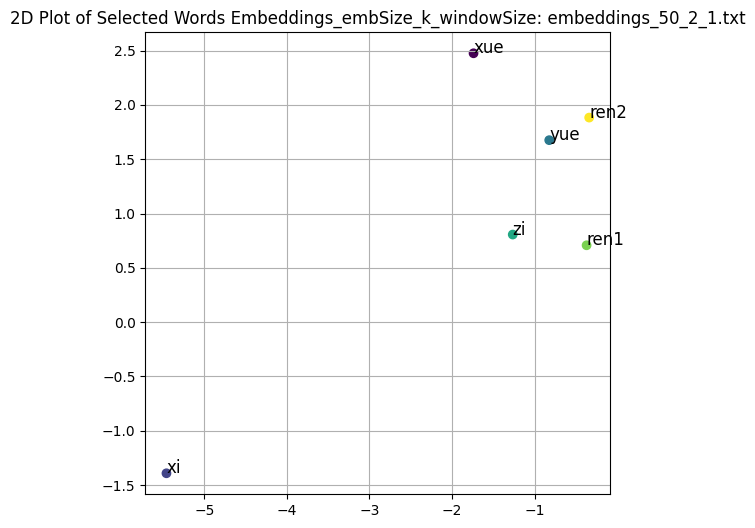

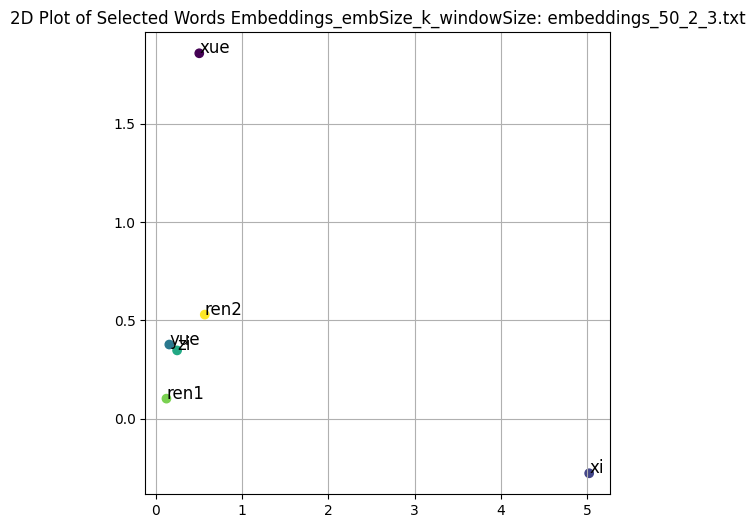

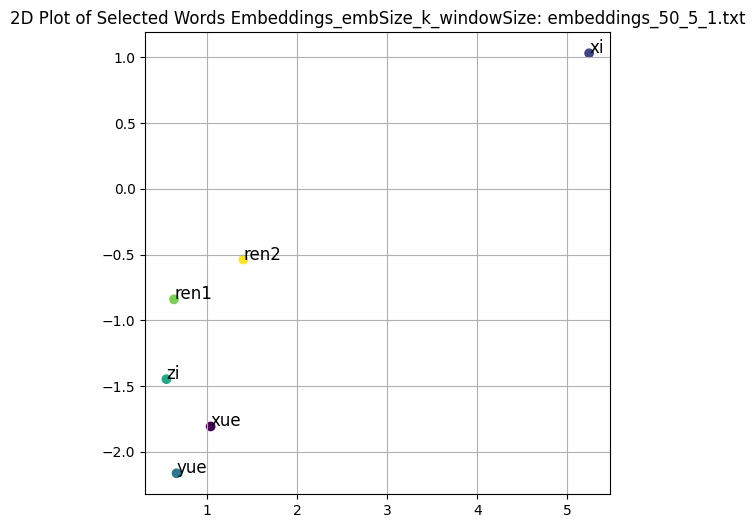

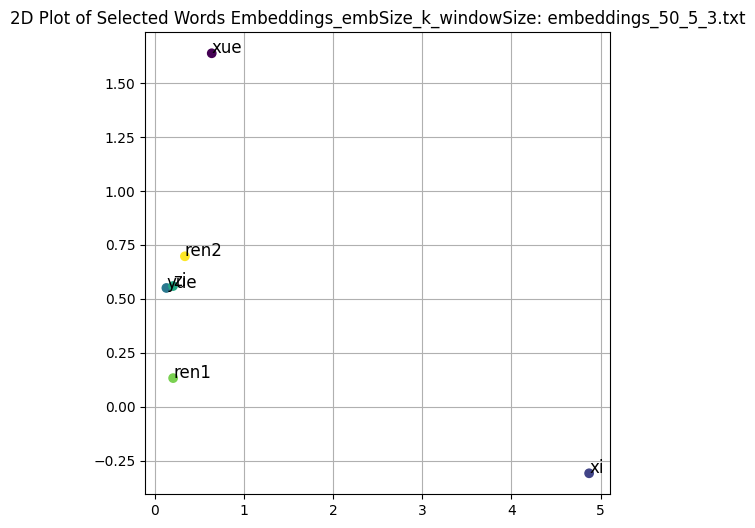

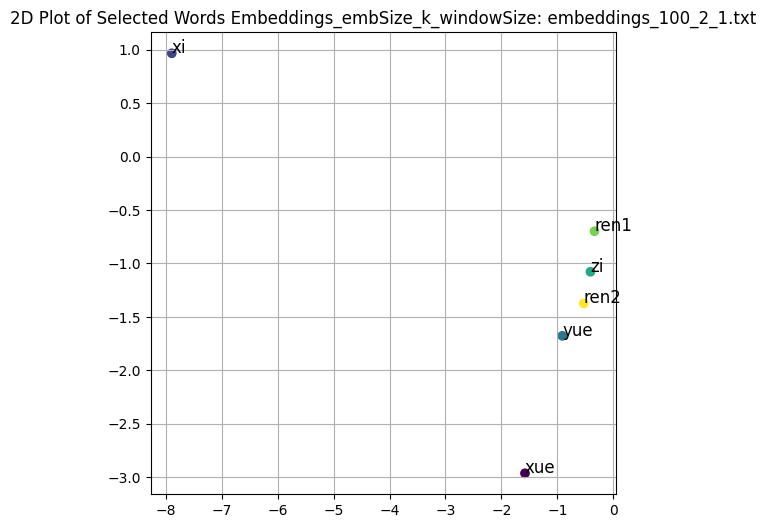

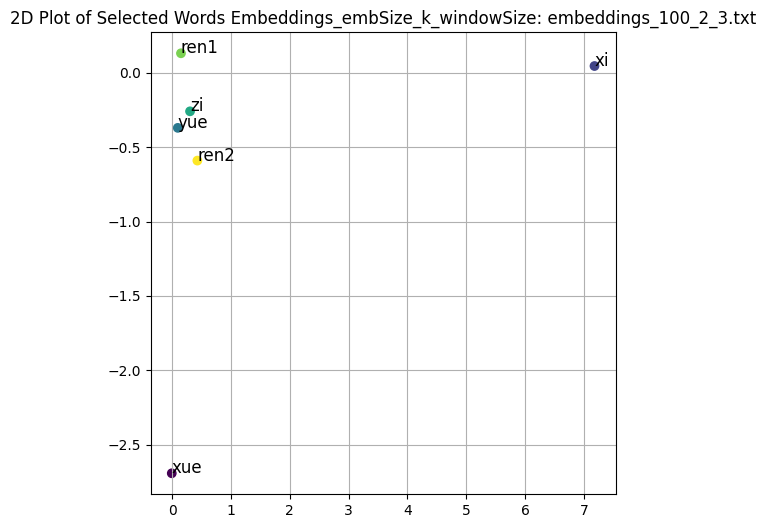

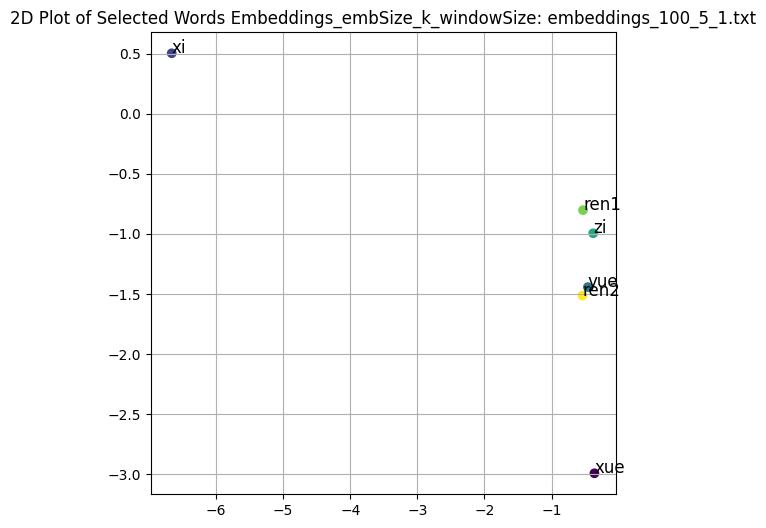

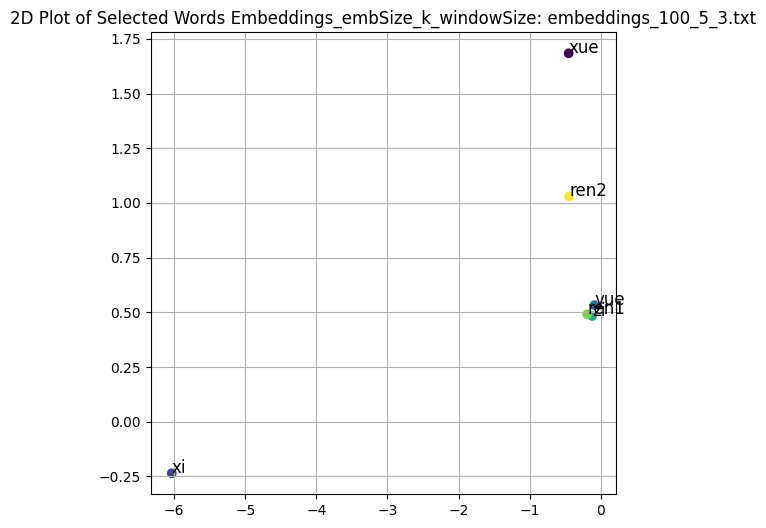

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import os

# Define the target words you want to plot
target_words = ['学', '习', '曰', '子', '人', '仁']

# Define the embedding files (you can add more files as needed)
embedding_files = [
    'embeddings_50_2_1.txt',
    'embeddings_50_2_3.txt',
    'embeddings_50_5_1.txt',
    'embeddings_50_5_3.txt',
    'embeddings_100_2_1.txt',
    'embeddings_100_2_3.txt',
    'embeddings_100_5_1.txt',
    'embeddings_100_5_3.txt'
]

# Loop through the embedding files and plot the embeddings
for embedding_file in embedding_files:
    embeddings = load_embeddings(embedding_file)

    # Extract embeddings for the target words
    target_embeddings = np.array([embeddings[word] for word in target_words if word in embeddings])

    # Apply Truncated SVD to reduce dimensionality to 2D
    svd = TruncatedSVD(n_components=2)
    reduced_embeddings = svd.fit_transform(target_embeddings)

    # Plot the 2D embeddings
    plt.figure(figsize=(6, 6))
    colors = np.linspace(0, 1, len(target_words))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors, cmap='viridis')

    # Annotate the words on the plot
    for i, word in enumerate(target_words):
        if word in embeddings:
            plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], words_pinyin[i], fontsize=12)

    plt.title(f'2D Plot of Selected Words Embeddings_embSize_k_windowSize: {embedding_file}')
    plt.grid(True)
    plt.show()
